<a href="https://colab.research.google.com/github/akshayonly/ML-Case-Study-Working-With-High-Dimensional-Clinical-Texts/blob/main/Classifying_Genetic_Mutation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Genetic mutation from high-dimensional clinical features

1. Packages

2. Downloading data

3. Preprocessing data

4. Primary data analysis

5. Data featurization

   1. Text Feature

      - TF-IDF

   2. Categorical Features
      - Response encoding

6. Secondary data analysis

   1. Visualizing high dimensional text features by t-SNE
   2. Visualizing Gene & Variation features by  t-SNE

7. ML model building

   1. Linear models
      1. SVM-RBF
      2. Logistic Regression (SGD)
   2. Ensemble models
      1. Random Forest
      2. XGBoost

8. Conclusion

**OBJECTIVE**

The goal of this case study is to understand how different featurization technique affects the overall machine learning model performance. 

<a name="cell-id1"></a>
# Packages

In [83]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

import re
from tqdm import tqdm
from datetime import datetime

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, balanced_accuracy_score

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')

palette = sns.color_palette("Paired", 9)
plt.style.use('seaborn-notebook')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
start=datetime.now()

# Downloading data

In [3]:
# Train Texts
! wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008860&Signature=QfJ5ZdxHSxKoXPlMr8jzZps8EhiRPj96kCzii0FAySYZ0Myn6iSyuSrlWe2ybDynfDRbakpZESoF88XRS6zV9PsPEXNNCVgM1IUGDjj%2FtqDa1NTTcCjwLEhiKFTT7pAFR6O%2BAMaQ0Cepi5ZPYVcUbI1cJcEiuHe0Nk0x%2FCkdTtZRgMCYONMycPdHTVj0dlOtniqxtx0N7yORbregcmI3kGgG%2BVa6n9EMJSZX5vbIC5AW1VodpzxsCqNgnjGCW51gnb0NmipZwxbnCJ%2FZb3fQRCuIiNtX7rOL%2BYGfnfnWZQRC21G5Xx4%2BX%2B%2FSPGFrg3FpdcmJHGVY8S%2FJKS8PQv3%2FCA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip' --output-document 'training_text.zip' && unzip training_text.zip

# Train Variants
! wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_variants.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008828&Signature=daXpYlinA3JfM6dRDJO81AddsFlJ07GrZA%2FGaJHfHrhDEx69HUbj24gbH2ahVgwwjZtZ6FICDEefb8IoJXXceQEZEMy53%2Ff9QgMhI7PBgPFtQ3KgdzZ3%2BipqvntyPQlsa92qCBBwC91iG65TMB%2B4AjfhqydDUEtjNXiySnndKWwt04FZqTtHRf3LBvhwpf5mdi9U3Duk%2FI%2BnxDyoRwo1b2ffV3CJbNWDJSuXnN%2Fu8BmiCqndjVN6fi772VeXHn9R3vsgYEs4g%2FhTUFzSn%2FaW0%2FPrtKVhx%2Fd3QuqhQUh3%2BVNoI9qvFBB%2BlyyfyYUNBMsxrd0Oi6zkPmM8R2q6TeSTzg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_variants.zip' --output-document 'training_variants.zip' && unzip training_variants.zip

--2021-03-28 10:02:59--  https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008860&Signature=QfJ5ZdxHSxKoXPlMr8jzZps8EhiRPj96kCzii0FAySYZ0Myn6iSyuSrlWe2ybDynfDRbakpZESoF88XRS6zV9PsPEXNNCVgM1IUGDjj%2FtqDa1NTTcCjwLEhiKFTT7pAFR6O%2BAMaQ0Cepi5ZPYVcUbI1cJcEiuHe0Nk0x%2FCkdTtZRgMCYONMycPdHTVj0dlOtniqxtx0N7yORbregcmI3kGgG%2BVa6n9EMJSZX5vbIC5AW1VodpzxsCqNgnjGCW51gnb0NmipZwxbnCJ%2FZb3fQRCuIiNtX7rOL%2BYGfnfnWZQRC21G5Xx4%2BX%2B%2FSPGFrg3FpdcmJHGVY8S%2FJKS8PQv3%2FCA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63917183 (61M) [application/zip]
Saving to: ‘training_text.zip’

training_text.zip   1

In [4]:
!ls -I *.zip

training_variants.zip


<a name="cell-id3"></a>
# Data Preprocessing

In [5]:
variants_data = pd.read_csv('/content/training_variants', index_col=False)
variants_data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
texts_data = pd.read_csv('/content/training_text', 
                         sep="\|\|", 
                         engine="python", 
                         names=["ID","TEXT"], 
                         skiprows=1)

texts_data.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Merging variants and texts dataframes

In [7]:
data = pd.merge(texts_data, variants_data, on='ID', how='left')

data.head()

,ID,TEXT,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


## Highlevel overview

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   TEXT       3316 non-null   object
 2   Gene       3321 non-null   object
 3   Variation  3321 non-null   object
 4   Class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


1. There are 3321 entries in the dataframe.
2. Leaving ``Class`` column which is numerical representation of genetic mutation classes, rest are object datatype i.e. categorical and text.
3. The ``TEXT`` column have 05 entries lesser than the total 3321, we'd look at them later.

In [9]:
data['Class'].describe()

count    3321.000000
mean        4.365854
std         2.309781
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: Class, dtype: float64

## Preprocessing

### NaN values

In [10]:
data[data.isnull().any(axis=1)]

,ID,TEXT,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


- There are 05 rows in the data in the ``'TEXT'`` column which are NaN
- We'd  remove them, as these are text base and we cannot replace them with other values.

In [11]:
data.dropna(subset = ["TEXT"], inplace=True)

### Standard NLP preprocessing
- Removing stop words
- Removing puntuations

In [12]:
stop_words = set(stopwords.words('english'))

def text_processing(text):
  """Processing the sentence (single entry)."""

  text = re.sub('\s+',' ', text)
  text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
  text = text.lower()

  tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

  return ' '.join(tokens)

In [13]:
for index, text in tqdm(data.TEXT.iteritems()):
  data["TEXT"][index] = text_processing(text)

3316it [02:40, 20.70it/s]


In [14]:
data.Gene = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

In [15]:
data.head(2)

,ID,TEXT,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate variety...,FAM58A,Truncating_Mutations,1
1,1,abstract background non small cell lung cancer...,CBL,W802*,2


In [16]:
# Copying newly created dataframe into csv
# data.to_csv('CGM-processed.csv', index=False)

In [17]:
# Copying to google drive
# !cp -r /content/CGM-processed.csv /content/drive/MyDrive/Data/CGV-Data

<a name="cell-id4"></a>
# Primary data analysis

## Distribution of ``Class``

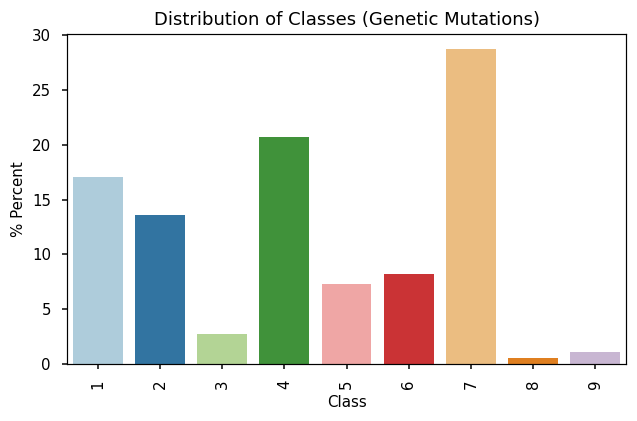

In [18]:
plt.figure(figsize=(6,4), dpi=108)
sns.barplot(x="Class", y="Class", data=data, palette=palette,
            estimator=lambda x: len(x) / len(data) * 100)
plt.ylabel('% Percent', fontsize=10)
plt.xlabel('Class', fontsize=10)
plt.xticks(rotation='vertical')
plt.title("Distribution of Classes (Genetic Mutations)", fontsize=12)
plt.tight_layout()
plt.show()

**Obsevation**
1. The class distribution is highly imbalanced. 
2. Most frequent genetic mutation classes are 7 (appx. 29%), followed by class 4 (appx. 21%).
3. Lowest occurancing classes are 8 and 9.
4. Due to presense of imbalance among classes, this can affect the predicition of the model, as it often noted that classes with major occurances tends to foreshadow those with less occurances.

<a name="cell-id5"></a>
# Data featurization

In [19]:
y = np.array(data['Class'].values)

In [20]:
X = data[data.columns[1:4]]

In [21]:
# Splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y)

In [22]:
x_train.shape

(2321, 3)

In [23]:
x_test.shape

(995, 3)

In [24]:
x_test.head()

,TEXT,Gene,Variation
2813,twenty percent individuals strong family perso...,BRCA2,R2502H
1414,frequent genetic alterations discovered fgfrs ...,FGFR3,R669G
2313,recent work highlighted roles jak janus kinase...,JAK1,L910P
2853,mutation screening breast ovarian cancer predi...,BRCA2,E462G
1901,mll translocations adult b cell precursor bcp ...,TET1,MLL-TET1_Fusion


## Categorical

In [25]:
# Create LabelBinzarizer object
one_hot = CountVectorizer()

# One-hot encode data
one_hot.fit(x_train['Gene'])

ohe_tr_gene = one_hot.transform(x_train['Gene'])
ohe_ts_gene = one_hot.transform(x_test['Gene'])

In [26]:
print(f"OneHotEncoded Gene: {ohe_tr_gene.shape}")
print(f"OneHotEncoded Gene: {ohe_ts_gene.shape}")

OneHotEncoded Gene: (2321, 243)
OneHotEncoded Gene: (995, 243)


In [27]:
# Create LabelBinzarizer object
one_hot = CountVectorizer()

# One-hot encode data
one_hot.fit(x_train['Variation'])

ohe_tr_var = one_hot.transform(x_train['Variation'])
ohe_ts_var = one_hot.transform(x_test['Variation'])

In [28]:
print(f"OneHotEncoded Variation (Train): {ohe_tr_var.shape}")
print(f"OneHotEncoded Variation (Test): {ohe_ts_var.shape}")

OneHotEncoded Variation (Train): (2321, 2142)
OneHotEncoded Variation (Test): (995, 2142)


## Text

### TF-IDF 

In [32]:
vec_start = datetime.now()

tfidf = TfidfVectorizer(ngram_range=(2, 4), 
                        max_features=3000).fit(x_train['TEXT'])

tfidf_tr_text = tfidf.transform(x_train['TEXT'])
tfidf_ts_text = tfidf.transform(x_test['TEXT'])

vec_end = datetime.now()
print(f"Took: {vec_end-vec_start}")

Took: 0:03:52.622848


In [33]:
tfidf_ts_text.shape

(995, 3000)

In [34]:
tfidf_tr_text.shape

(2321, 3000)

In [35]:
round(np.sqrt(3000))

55

In [37]:
%xdel tfidf

## Concatenation

In [38]:
train = np.hstack((tfidf_tr_text.toarray(), 
                   ohe_tr_var.toarray(), 
                   ohe_tr_gene.toarray()))

test = np.hstack((tfidf_ts_text.toarray(), 
                  ohe_ts_var.toarray(), 
                  ohe_ts_gene.toarray()))

In [39]:
print(f"Train X: {train.shape}\ty: {y_train.shape}")
print(f"Test X: {test.shape}\ty: {y_test.shape}")

Train X: (2321, 5385)	y: (2321,)
Test X: (995, 5385)	y: (995,)


<a name="cell-id6"></a>
# Secondary data analysis

In [42]:
# Reducing dimension and projecting it onto 2D with t-SNE
train_tsne = TSNE(n_components=2, perplexity=50).fit_transform(train) 

# Reducing dimension and projecting it onto 2D with t-SNE
test_tsne = TSNE(n_components=2, perplexity=50).fit_transform(test) 

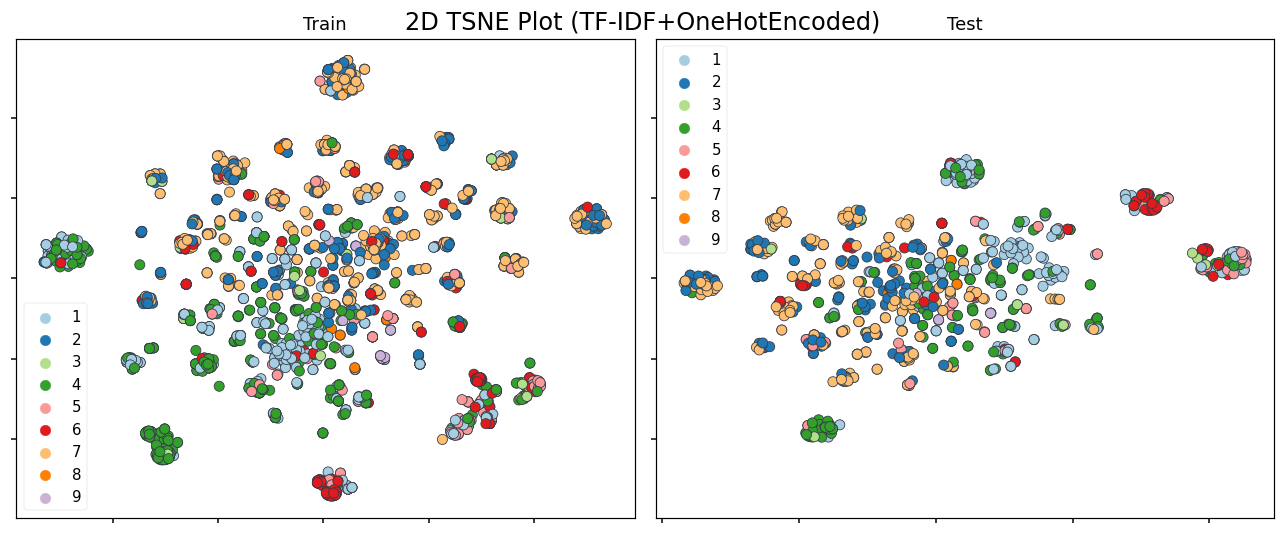

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=108, sharey=True)
fig.suptitle('2D TSNE Plot (TF-IDF+OneHotEncoded)', fontsize=16)

sns.scatterplot(ax=axes[0], x=train_tsne[:,0], y=train_tsne[:,1], 
                edgecolor='#353b48', hue=y_train, legend='full', 
                palette=palette, s=45)
axes[0].set_title("Train")
axes[0].set_yticklabels([])
axes[0].set_xticklabels([])
axes[0].grid(False)

sns.scatterplot(ax=axes[1], x=test_tsne[:,0], y=test_tsne[:,1], 
                edgecolor='#353b48',
                hue=y_test, legend='full', palette=palette, s=45)
axes[1].set_title("Test")
axes[1].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].grid(False)
plt.tight_layout()
plt.savefig('2D-TSNE-Plot.png', dpi=256)

# Machine learning model

## Ensemble-Based
- Random Forest

### Random Forest

In [80]:
rf_params={
    'bootstrap': [True],
    'max_depth': [5, 10, 20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4, 7],
    'n_estimators': [500, 1000, 1500]}

In [81]:
rf=RandomForestClassifier(n_jobs=-1)

gscv = GridSearchCV(rf, param_grid=rf_params, n_jobs=-1, verbose=2).\
                    fit(train, y_train)

gscv.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.0min finished


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'n_estimators': 1000}

Train Accuracy:	0.6135914090856067
Test Accuracy:	0.4051811122021872

----------------------------------------------------------------------------------------------------

Train F1 Score (Micro):	1
Test F1 Score (Micro):	1

----------------------------------------------------------------------------------------------------

Train F1 Score (Macro):	1
Test F1 Score (Macro):	0

----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Test')

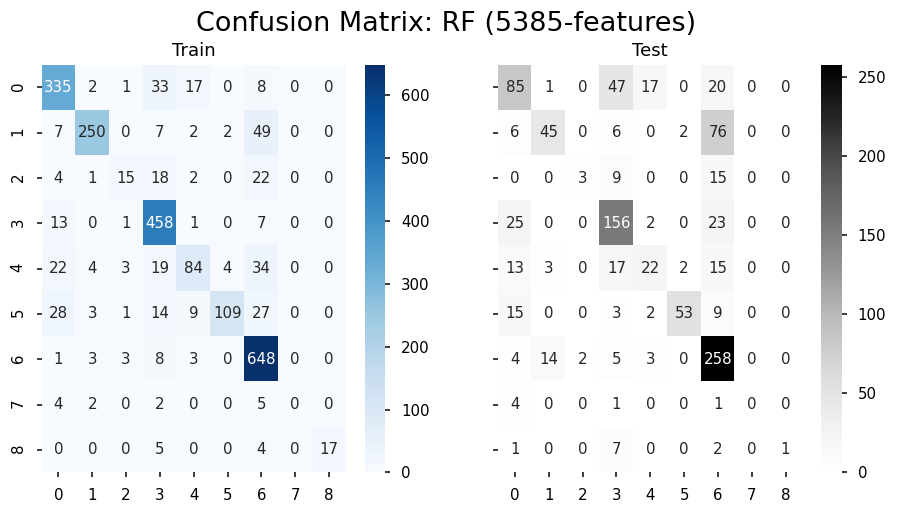

In [82]:
rf = RandomForestClassifier(bootstrap=gscv.best_params_['bootstrap'], 
                        max_depth=gscv.best_params_['max_depth'], 
                        max_features=gscv.best_params_['max_features'],
                        min_samples_leaf=gscv.best_params_['min_samples_leaf'],
                        n_estimators=gscv.best_params_['n_estimators'], n_jobs=-1).\
                        fit(train, y_train)

# Prediction
y_predtest = rf.predict(test)
y_predtrain = rf.predict(train)

# Accuracy
print(f"Train Accuracy:\t{balanced_accuracy_score(y_train, y_predtrain)}")
print(f"Test Accuracy:\t{balanced_accuracy_score(y_test, y_predtest)}\n")

print("-"*100)
# F1 micro Score
f1_score_1_log_train = f1_score(y_train, y_predtrain, average='micro')
f1_score_1_log_test = f1_score(y_test, y_predtest , average='micro')

print(f"\nTrain F1 Score (Micro):\t{round(f1_score_1_log_train)}")
print(f"Test F1 Score (Micro):\t{round(f1_score_1_log_test)}\n")

print("-"*100)
# F1 macro Score
f1_score_2_log_train = f1_score(y_train, y_predtrain, average='macro')
f1_score_2_log_test = f1_score(y_test, y_predtest , average='macro')

print(f"\nTrain F1 Score (Macro):\t{round(f1_score_2_log_train)}")
print(f"Test F1 Score (Macro):\t{round(f1_score_2_log_test)}\n")

print("-"*100)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=108, sharey=True)
fig.suptitle(f'Confusion Matrix: RF ({train.shape[1]}-features)', 
             fontsize=18)

cm1 = confusion_matrix(y_train, y_predtrain)
sns.heatmap(cm1, annot=True,fmt="d",cmap='Blues', ax=axes[0])
axes[0].set_title('Train')

cm2 = confusion_matrix(y_test, y_predtest)
sns.heatmap(cm2, annot=True,fmt="d",cmap='Greys', ax=axes[1])
axes[1].set_title('Test')

### Feature Importances

In [127]:
# Getting the indices for features with non zero values
imp_feat_idx = (np.nonzero(rf.feature_importances_))[0]

# Selecting non zero features from train and test
x_train_top_feat = (train[:, imp_feat_idx])
x_test_top_feat = (test[:, imp_feat_idx])

(3043,)

### Training with reduced feature space

In [129]:
rf=RandomForestClassifier(n_jobs=-1)

gscv = GridSearchCV(rf, param_grid=rf_params, n_jobs=-1, verbose=2).\
                    fit(x_train_top_feat, y_train)

print(gscv.best_params_)

rf = RandomForestClassifier(bootstrap=gscv.best_params_['bootstrap'], 
                        max_depth=gscv.best_params_['max_depth'], 
                        max_features=gscv.best_params_['max_features'],
                        min_samples_leaf=gscv.best_params_['min_samples_leaf'],
                        n_estimators=gscv.best_params_['n_estimators'], n_jobs=-1).\
                        fit(x_train_top_feat, y_train)

# Prediction
y_predtest = rf.predict(x_test_top_feat)
y_predtrain = rf.predict(x_train_top_feat)

# Accuracy
print(f"Train Accuracy:\t{balanced_accuracy_score(y_train, y_predtrain)}")
print(f"Test Accuracy:\t{balanced_accuracy_score(y_test, y_predtest)}\n")

print("-"*100)
# F1 micro Score
f1_score_1_log_train = f1_score(y_train, y_predtrain, average='micro')
f1_score_1_log_test = f1_score(y_test, y_predtest , average='micro')

print(f"\nTrain F1 Score (Micro):\t{round(f1_score_1_log_train)}")
print(f"Test F1 Score (Micro):\t{round(f1_score_1_log_test)}\n")

print("-"*100)
# F1 macro Score
f1_score_2_log_train = f1_score(y_train, y_predtrain, average='macro')
f1_score_2_log_test = f1_score(y_test, y_predtest , average='macro')

print(f"\nTrain F1 Score (Macro):\t{round(f1_score_2_log_train)}")
print(f"Test F1 Score (Macro):\t{round(f1_score_2_log_test)}\n")

print("-"*100)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=108, sharey=True)
fig.suptitle(f'Confusion Matrix: RF ({x_train_top_feat.shape[1]}-features)', 
             fontsize=18)

cm1 = confusion_matrix(y_train, y_predtrain)
sns.heatmap(cm1, annot=True,fmt="d",cmap='Blues', ax=axes[0])
axes[0].set_title('Train')

cm2 = confusion_matrix(y_test, y_predtest)
sns.heatmap(cm2, annot=True,fmt="d",cmap='Greys', ax=axes[1])
axes[1].set_title('Test')

## Neighbourhood-Based
- k-Nearest Neighbours

In [69]:
params = {
    'n_neighbors':[13, 21, 27],
    'algorithm':['kd_tree'],
    'weights':['distance']
    }

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   50.6s finished




Took 0:00:52.490780 time to find best parameters:
	{'algorithm': 'kd_tree', 'n_neighbors': 13, 'weights': 'distance'}


----------------------------------------------------------------------------------------------------
Train Accuracy:	1.0
Test Accuracy:	0.43922298567007984

----------------------------------------------------------------------------------------------------

Train F1 Score (Micro):	1.0
Test F1 Score (Micro):	0.6180904522613065

----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Test')

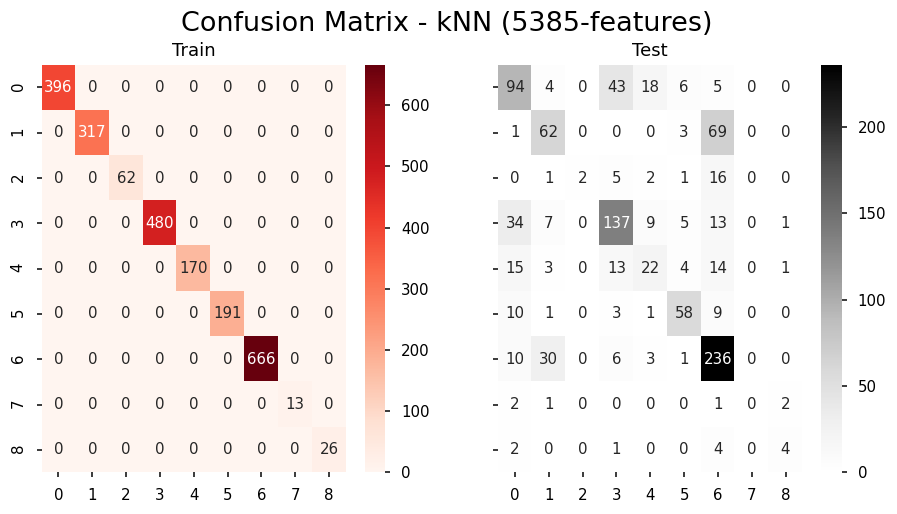

In [70]:
knn = KNeighborsClassifier(n_jobs=-1)

knn_cv_start = datetime.now()
knn_cv = GridSearchCV(knn, param_grid=params, cv=5, 
                      verbose=2, n_jobs=-1).fit(x_train_top_feat, y_train) 
knn_cv_end= datetime.now()

best_knn=knn_cv.best_params_

print(f"\n\nTook {knn_cv_end-knn_cv_start} time to find best parameters:\n\t{best_knn}\n\n")

knn = KNeighborsClassifier(n_neighbors=best_knn['n_neighbors'],
                           weights=best_knn['weights'],
                           algorithm=best_knn['algorithm'],
                           n_jobs=-1)

knn.fit(x_train_top_feat, y_train) 

# Prediction
y_predtest = knn.predict(x_test_top_feat)
y_predtrain = knn.predict(x_train_top_feat)

# Accuracy
print("-"*100)
print(f"Train Accuracy:\t{balanced_accuracy_score(y_train, y_predtrain)}")
print(f"Test Accuracy:\t{balanced_accuracy_score(y_test, y_predtest)}\n")

# F1 Score
print("-"*100)
print(f"\nTrain F1 Score (Micro):\t{f1_score(y_train, y_predtrain, average='micro')}")
print(f"Test F1 Score (Micro):\t{f1_score(y_test, y_predtest , average='micro')}\n")

print("-"*100)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=108, sharey=True)
fig.suptitle(f'Confusion Matrix - kNN ({x_train_top_feat.shape[1]}-features)', fontsize=18)

cm1 = confusion_matrix(y_train, y_predtrain)
sns.heatmap(cm1, annot=True,fmt="d",cmap='Reds', ax=axes[0])
axes[0].set_title('Train')

cm2 = confusion_matrix(y_test, y_predtest)
sns.heatmap(cm2, annot=True,fmt="d",cmap='Greys', ax=axes[1])
axes[1].set_title('Test')

## Linear Models
- SVM & Logistic Regression with Stochastic Gradient Descent

### SVM with Stochastic Gradient Descent

In [130]:
params = {'loss': ['hinge'], 
          'penalty': ['l1', 'l2', 'elasticnet'],
          'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'class_weight': ['balanced'],
          'max_iter':[250, 500]}          

In [ ]:
sgd_svm = SGDClassifier(n_jobs=-1, early_stopping=False)

gsv = GridSearchCV(sgd_svm, param_grid=params, n_jobs=-1, cv=5, verbose=2)

gsv.fit(x_train_top_feat, y_train)

In [46]:
gsv.best_params_

{'alpha': 0.0001,
 'class_weight': 'balanced',
 'loss': 'hinge',
 'max_iter': 500,
 'penalty': 'elasticnet'}

----------------------------------------------------------------------------------------------------
Train Accuracy:	0.9985567323369637
Test Accuracy:	0.5826420059175557

----------------------------------------------------------------------------------------------------

Train F1 Score (Micro):	0.997414907367514
Test F1 Score (Micro):	0.6673366834170854

----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Test')

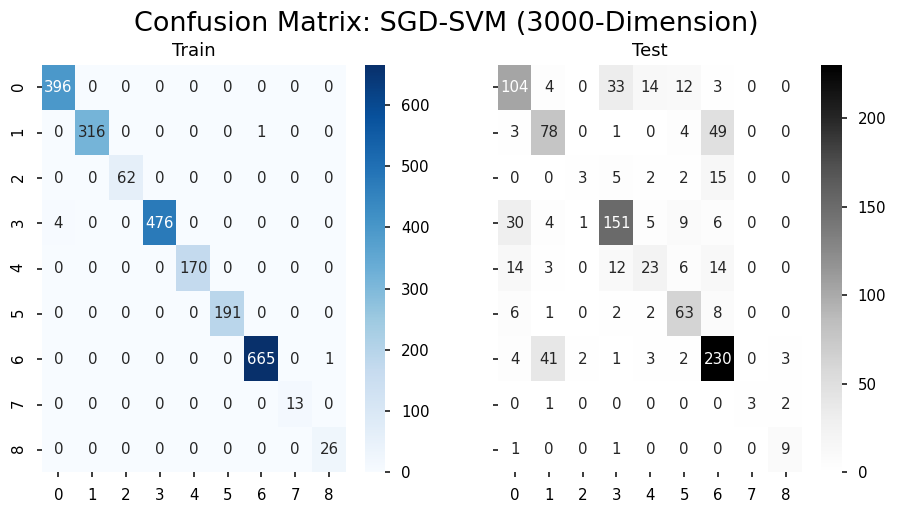

In [47]:
sgd_svm = SGDClassifier(alpha=gsv.best_params_['alpha'], 
                        loss=gsv.best_params_['loss'], 
                        penalty=gsv.best_params_['penalty'],
                        max_iter=gsv.best_params_['max_iter'],
                        class_weight=gsv.best_params_['class_weight'],
                        n_jobs=-1, early_stopping=False).\
                        fit(x_train_top_feat, y_train)

# Prediction
y_predtest = sgd_svm.predict(x_test_top_feat)
y_predtrain = sgd_svm.predict(x_train_top_feat)

# Accuracy
print("-"*100)
print(f"Train Accuracy:\t{balanced_accuracy_score(y_train, y_predtrain)}")
print(f"Test Accuracy:\t{balanced_accuracy_score(y_test, y_predtest)}\n")

# F1 Score
print("-"*100)
print(f"\nTrain F1 Score (Micro):\t{f1_score(y_train, y_predtrain, average='micro')}")
print(f"Test F1 Score (Micro):\t{f1_score(y_test, y_predtest , average='micro')}\n")

print("-"*100)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=108, sharey=True)
fig.suptitle(f'Confusion Matrix: SGD-SVM ({x_train_top_feat.shape[1]}-features)', 
             fontsize=18)

cm1 = confusion_matrix(y_train, y_predtrain)
sns.heatmap(cm1, annot=True,fmt="d",cmap='Blues', ax=axes[0])
axes[0].set_title('Train')

cm2 = confusion_matrix(y_test, y_predtest)
sns.heatmap(cm2, annot=True,fmt="d",cmap='Greys', ax=axes[1])
axes[1].set_title('Test')

### Logistic Regression with Stochastic Gradient Descent

In [132]:
params = {'loss': ['log'], 
          'penalty': ['l1', 'l2', 'elasticnet'],
          'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'class_weight': ['balanced'],
          'max_iter':[250, 500]} 

In [ ]:
sgd_log = SGDClassifier(n_jobs=-1, early_stopping=False)

gsv = GridSearchCV(sgd_log, param_grid=params, n_jobs=-1, cv=5, verbose=2)

gsv.fit(x_train_top_feat, y_train)

In [59]:
gsv.best_params_

{'alpha': 0.0001,
 'class_weight': 'balanced',
 'loss': 'log',
 'max_iter': 250,
 'penalty': 'elasticnet'}

Train Accuracy:	0.992544548138505
Test Accuracy:	0.57517008592213

----------------------------------------------------------------------------------------------------

Train F1 Score (Micro):	1
Test F1 Score (Micro):	1

----------------------------------------------------------------------------------------------------

Train F1 Score (Macro):	1
Test F1 Score (Macro):	1

----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Test')

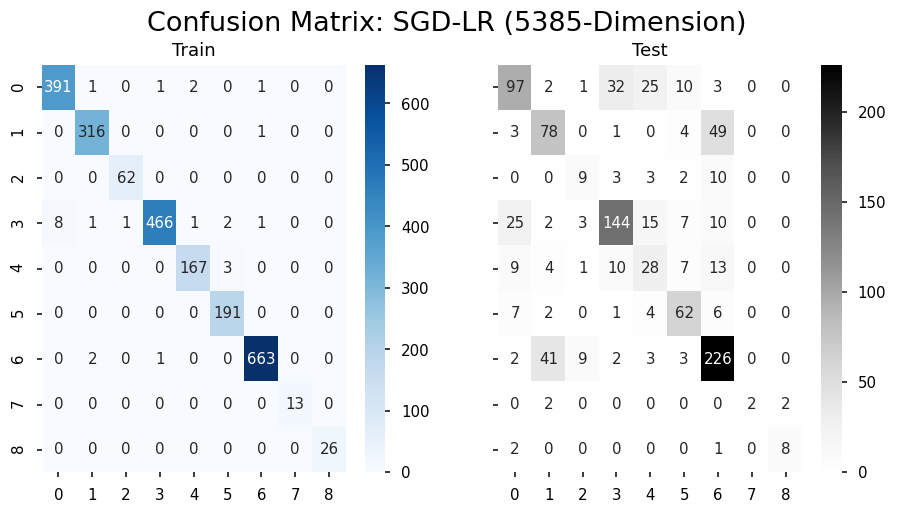

In [51]:
sgd_log = SGDClassifier(alpha=gsv.best_params_['alpha'], 
                        loss=gsv.best_params_['loss'], 
                        penalty=gsv.best_params_['penalty'],
                        max_iter=gsv.best_params_['max_iter'],
                        class_weight=gsv.best_params_['class_weight'],
                        n_jobs=-1, early_stopping=False).\
                        fit(x_train_top_feat, y_train)

# Prediction
y_predtest = sgd_log.predict(x_test_top_feat)
y_predtrain = sgd_log.predict(x_train_top_feat)

# Accuracy
print(f"Train Accuracy:\t{balanced_accuracy_score(y_train, y_predtrain)}")
print(f"Test Accuracy:\t{balanced_accuracy_score(y_test, y_predtest)}\n")

print("-"*100)
# F1 micro Score
f1_score_1_log_train = f1_score(y_train, y_predtrain, average='micro')
f1_score_1_log_test = f1_score(y_test, y_predtest , average='micro')

print(f"\nTrain F1 Score (Micro):\t{round(f1_score_1_log_train)}")
print(f"Test F1 Score (Micro):\t{round(f1_score_1_log_test)}\n")

print("-"*100)
# F1 macro Score
f1_score_2_log_train = f1_score(y_train, y_predtrain, average='macro')
f1_score_2_log_test = f1_score(y_test, y_predtest , average='macro')

print(f"\nTrain F1 Score (Macro):\t{round(f1_score_2_log_train)}")
print(f"Test F1 Score (Macro):\t{round(f1_score_2_log_test)}\n")

print("-"*100)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=108, sharey=True)
fig.suptitle(f'Confusion Matrix: SGD-LR ({x_train_top_feat.shape[1]}-features)', 
             fontsize=18)

cm1 = confusion_matrix(y_train, y_predtrain)
sns.heatmap(cm1, annot=True,fmt="d",cmap='Blues', ax=axes[0])
axes[0].set_title('Train')

cm2 = confusion_matrix(y_test, y_predtest)
sns.heatmap(cm2, annot=True,fmt="d",cmap='Greys', ax=axes[1])
axes[1].set_title('Test')

<a name="cell-id8"></a>
# Conclusion

In [52]:
end=datetime.now()

print(f"Time took for whole Notebook - {end-start}")

Time took for whole Notebook - 0:34:00.125211


In [53]:
! rm /content/training_variants

In [54]:
! rm /content/training_text

In [55]:
! rm -I *.zip